# Projet : Analyse des sentiments (Jour 1)
## Analyse lexicale + Supervision (Naive Bayes)

Ce notebook est une **version corrigée et améliorée** du notebook initial, alignée sur le syllabus du module :
- **Préparer et conduire une analyse lexicale** : nettoyage, tokenisation, stopwords, lemmatisation, POS tagging, lexicon-based, score de sentiment
- **Mettre en œuvre une approche supervisée** : TF / TF-IDF, train/test, Naive Bayes, analyse des features influentes


## 0) Setup (une fois)

Exécutez la cellule suivante **uniquement si nécessaire** (première exécution sur un environnement vierge).


In [1]:
import sys, subprocess

def pip_install(packages):
    # Installe des packages dans l'environnement du kernel Jupyter
    cmd = [sys.executable, "-m", "pip", "install", "-U"] + packages
    print("Commande:", " ".join(cmd))
    subprocess.check_call(cmd)

# Décommentez si besoin :
# pip_install(["pandas","numpy","matplotlib","seaborn","nltk","spacy","textblob","vaderSentiment","wordcloud","scikit-learn"])


## 0.1) Ressources NLTK à télécharger

`word_tokenize` et certains outils NLTK nécessitent des ressources (ex: Punkt).


In [2]:
import nltk

# Téléchargements sûrs (ne retélécharge pas si déjà présent)
for pkg in ["punkt", "punkt_tab", "stopwords", "wordnet", "omw-1.4"]:
    try:
        nltk.download(pkg, quiet=True)
    except Exception as e:
        print(f"[WARN] Téléchargement NLTK échoué pour {pkg}: {e}")

print("NLTK ready")


NLTK ready


## 1) Imports


In [3]:
import re
import string
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set()


## 2) Collecte / chargement du corpus

### Option A — Charger un fichier
Adaptez les colonnes si besoin :
- `text` : avis
- `rating` : note (ex: 1..5)

### Option B — Dataset d’exemple (fourni ici)
On garde un petit corpus bilingue (FR/EN) pour illustrer les difficultés multilingues.


In [4]:
# Option A (décommenter) : charger un CSV
# df = pd.read_csv("votre_fichier.csv")
# df = df.rename(columns={"col_texte":"text", "col_note":"rating"})

# Option B : mini dataset d'exemple
reviews_data = [
    {"text": "Produit excellent, livraison rapide, je recommande !", "rating": 5, "lang": "fr"},
    {"text": "Très déçu. La qualité est mauvaise et le service client ne répond pas.", "rating": 1, "lang": "fr"},
    {"text": "Correct mais rien d'exceptionnel.", "rating": 3, "lang": "fr"},
    {"text": "Super, encore un produit qui ne fonctionne pas... génial !", "rating": 1, "lang": "fr"},
    {"text": "Amazing quality, fast delivery. Very satisfied!", "rating": 5, "lang": "en"},
    {"text": "Terrible experience. The product broke after one day.", "rating": 1, "lang": "en"},
    {"text": "Not bad, but could be better for the price.", "rating": 3, "lang": "en"},
    {"text": "Great customer service but the product is disappointing.", "rating": 2, "lang": "en"},
]

df = pd.DataFrame(reviews_data)
df.head()


,text,rating,lang
0,"Produit excellent, livraison rapide, je recomm...",5,fr
1,Très déçu. La qualité est mauvaise et le servi...,1,fr
2,Correct mais rien d'exceptionnel.,3,fr
3,"Super, encore un produit qui ne fonctionne pas...",1,fr
4,"Amazing quality, fast delivery. Very satisfied!",5,en


## 2.1) Exploration rapide (EDA)


,rating,lang,text_length,word_count
count,8.000000,8,8.000000,8.000000
unique,NaN,2,NaN,NaN
top,NaN,fr,NaN,NaN
freq,NaN,4,NaN,NaN
mean,2.625000,NaN,51.500000,8.125000
std,1.685018,NaN,10.967484,2.695896
min,1.000000,NaN,33.000000,4.000000
25%,1.000000,NaN,46.000000,6.750000
50%,2.500000,NaN,52.500000,8.000000
75%,3.500000,NaN,56.500000,9.250000


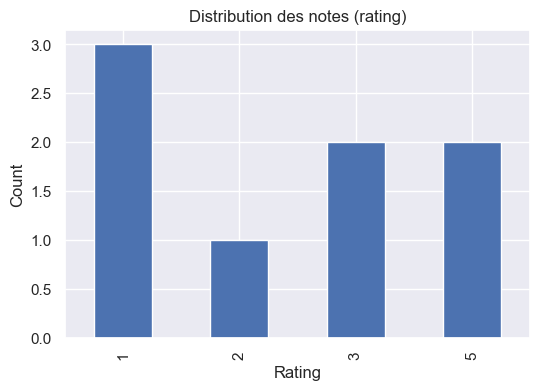

In [5]:
df["text_length"] = df["text"].astype(str).apply(len)
df["word_count"] = df["text"].astype(str).apply(lambda x: len(x.split()))

display(df[["rating","lang","text_length","word_count"]].describe(include="all"))

plt.figure(figsize=(6,4))
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution des notes (rating)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


## 2.2) Création d'une étiquette de sentiment (baseline)

Pour l’évaluation, on transforme la note en 3 classes :
- `negative` : rating ≤ 2
- `neutral`  : rating = 3
- `positive` : rating ≥ 4


In [6]:
def rating_to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment"] = df["rating"].apply(rating_to_sentiment)
df[["rating","sentiment","text"]].head()


,rating,sentiment,text
0,5,positive,"Produit excellent, livraison rapide, je recomm..."
1,1,negative,Très déçu. La qualité est mauvaise et le servi...
2,3,neutral,Correct mais rien d'exceptionnel.
3,1,negative,"Super, encore un produit qui ne fonctionne pas..."
4,5,positive,"Amazing quality, fast delivery. Very satisfied!"


## 3) Préparation des données (Nettoyage + Tokenisation + Stopwords + Lemmatisation + POS)

Le preprocessing est une étape cruciale en NLP. Les étapes typiques incluent :

1. **Nettoyage** : suppression HTML, URLs, caractères spéciaux
2. **Normalisation** : lowercase, accents
3. **Tokenisation** : découpage en mots
4. **Stopwords** : suppression des mots vides (le, la, un, de...)
5. **Lemmatisation/Stemming** : réduction à la forme canonique
6. **POS Tagging** : identification des parties du discours

⚠️ **Attention** : Pour l'analyse de sentiments, certaines étapes doivent être adaptées :
- Ne pas supprimer la ponctuation (!!!, ???) qui porte du sens
- Attention aux négations ("ne", "pas") qui sont des stopwords mais essentielles
- Le lowercase peut faire perdre l'emphase (SUPER vs super)
> Version robuste : stopwords FR + EN, et on **conserve les négations** (important en sentiment).

In [7]:
# Stopwords FR + EN (NLTK)
stop_fr = set(stopwords.words("french"))
stop_en = set(stopwords.words("english"))
stop_all = stop_fr | stop_en
stop_all

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ai',
 'aie',
 'aient',
 'aies',
 'ain',
 'ait',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'au',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'ce',
 'ces',
 'couldn',
 "couldn't",
 'd',
 'dans',
 'de',
 'des',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'du',
 'during',
 'each',
 'elle',
 'en',
 'es',
 'est',
 'et',
 'eu',
 'eue',
 'eues',
 'eurent',
 'eus',
 'eusse',
 'eussent',
 'eusses',
 'eussiez',
 'eussions',
 'eut',
 'eux',
 'eûmes',
 'eût',
 'eûtes',
 'few',
 'for',
 'from',
 'furent',
 'furth

In [8]:
# On garde les négations (très utiles en sentiment)
NEGATIONS = {"ne", "pas", "jamais", "rien", "plus", "aucun", "sans", "not", "no", "never", "n't"}
stop_for_cloud_and_models = stop_all - NEGATIONS

In [9]:
# Nettoyage minimal : on garde ! ? (peuvent porter du sentiment)
PUNCT_TO_REMOVE = set(string.punctuation) - set(["!", "?"])

In [10]:
def basic_clean(text: str) -> str:
    text = str(text)
    text = re.sub(r"http\S+|www\S+", " ", text)  # URLs
    text = re.sub(r"<.*?>", " ", text)            # HTML
    text = re.sub(r"\s+", " ", text).strip()     # espaces multiples
    return text
df["text_clean"] = df["text"].apply(basic_clean)

In [11]:
def tokenize(text: str):
    return word_tokenize(text)
df["tokens"] = df["text_clean"].apply(tokenize)

In [12]:
def normalize_tokens(tokens):
    out = []
    for t in tokens:
        t = t.lower()

        # retire ponctuation (sauf ! ?)
        if t in PUNCT_TO_REMOVE:
            continue

        # retire tokens trop courts (évite n, t, etc.)
        if len(t) <= 2 and t not in NEGATIONS:
            continue

        # retire stopwords (sauf négations)
        if t in stop_for_cloud_and_models:
            continue

        # conserve les tokens contenant au moins une lettre
        if not re.search(r"[a-zA-ZÀ-ÿ]", t):
            continue

        out.append(t)
    return out

df["tokens"] = df["tokens"].apply(normalize_tokens)

In [13]:
df[["text","text_clean","tokens"]].head()

,text,text_clean,tokens
0,"Produit excellent, livraison rapide, je recomm...","Produit excellent, livraison rapide, je recomm...","[produit, excellent, livraison, rapide, recomm..."
1,Très déçu. La qualité est mauvaise et le servi...,Très déçu. La qualité est mauvaise et le servi...,"[très, déçu, qualité, mauvaise, service, clien..."
2,Correct mais rien d'exceptionnel.,Correct mais rien d'exceptionnel.,"[correct, rien, d'exceptionnel]"
3,"Super, encore un produit qui ne fonctionne pas...","Super, encore un produit qui ne fonctionne pas...","[super, encore, produit, ne, fonctionne, pas, ..."
4,"Amazing quality, fast delivery. Very satisfied!","Amazing quality, fast delivery. Very satisfied!","[amazing, quality, fast, delivery, satisfied]"


### 3.1) WordCloud

On utilise `tokens` filtrés → plus de stopwords dominants.

In [14]:
all_words = [w for toks in df["tokens"] for w in toks]
freq = Counter(all_words)
print("Top 20 mots:", freq.most_common(20))

Top 20 mots: [('produit', 2), ('service', 2), ('ne', 2), ('pas', 2), ('product', 2), ('excellent', 1), ('livraison', 1), ('rapide', 1), ('recommande', 1), ('très', 1), ('déçu', 1), ('qualité', 1), ('mauvaise', 1), ('client', 1), ('répond', 1), ('correct', 1), ('rien', 1), ("d'exceptionnel", 1), ('super', 1), ('encore', 1)]


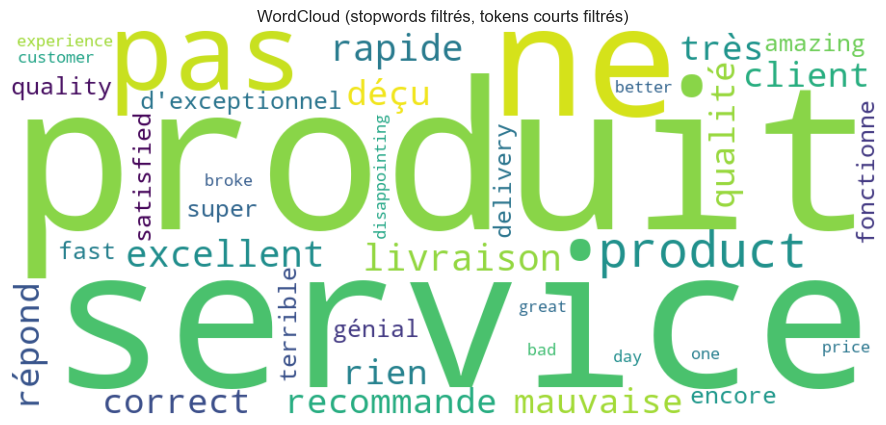

In [15]:
plt.figure(figsize=(12,5))
wc = WordCloud(width=900, height=400, background_color="white", collocations=False)
wc.generate(" ".join(all_words))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud (stopwords filtrés, tokens courts filtrés)")
plt.show()

### 3.2) Lemmatisation + POS tagging (spaCy)

Optionnel : nécessite `en_core_web_sm` et/ou `fr_core_news_sm`.


In [16]:
import spacy
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")

In [17]:
def spacy_process(text, lang):
    nlp = nlp_en if lang == "en" else nlp_fr
    if nlp is None:
        return [], []
    doc = nlp(text)
    lemmas = []
    pos_tags = []
    for tok in doc:
        if tok.is_space:
            continue
        lem = tok.lemma_.lower()
        if lem in stop_for_cloud_and_models and lem not in NEGATIONS:
            continue
        if len(lem) <= 2 and lem not in NEGATIONS:
            continue
        if lem in PUNCT_TO_REMOVE:
            continue
        if not re.search(r"[a-zA-ZÀ-ÿ]", lem):
            continue
        lemmas.append(lem)
        pos_tags.append(tok.pos_)
    return lemmas, pos_tags

tmp = []
for _, row in df.iterrows():
    lem, pos = spacy_process(row["text_clean"], row["lang"])
    tmp.append((lem, pos))

df["lemmas"] = [t[0] for t in tmp]
df["pos"] = [t[1] for t in tmp]

df[["lang","text_clean","lemmas","pos"]].head()

,lang,text_clean,lemmas,pos
0,fr,"Produit excellent, livraison rapide, je recomm...","[produit, excellent, livraison, rapide, recomm...","[PROPN, ADV, NOUN, ADJ, VERB]"
1,fr,Très déçu. La qualité est mauvaise et le servi...,"[très, déçu, qualité, être, mauvais, service, ...","[ADV, ADJ, NOUN, AUX, ADJ, NOUN, ADV, ADV, VER..."
2,fr,Correct mais rien d'exceptionnel.,"[correct, rien, exceptionnel]","[NOUN, PRON, ADJ]"
3,fr,"Super, encore un produit qui ne fonctionne pas...","[super, encore, produit, ne, fonctionner, pas,...","[PROPN, ADV, NOUN, ADV, VERB, ADV, ADJ]"
4,en,"Amazing quality, fast delivery. Very satisfied!","[amazing, quality, fast, delivery, satisfied]","[ADJ, NOUN, ADJ, NOUN, ADJ]"


## 4) Analyse lexicon-based (polarité) + score de sentiment
### 4.1 Utilisation de VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) est un lexique optimisé pour les textes des réseaux sociaux.

**Points forts de VADER :**
- Gère les émojis et émoticônes
- Sensible à la ponctuation (!!!)
- Détecte l'emphase (CAPITALES)
- Comprend les intensificateurs (très, extrêmement)
- Gère la négation de base

**Scores retournés :**
- `neg` : score négatif [0, 1]
- `neu` : score neutre [0, 1]
- `pos` : score positif [0, 1]
- `compound` : score composé normalisé [-1, 1]

**Règle de classification :**
- compound ≥ 0.05 → POSITIF
- compound ≤ -0.05 → NÉGATIF
- sinon → NEUTRE

> Important : VADER est conçu surtout pour l’anglais (même s’il peut “réagir” à ponctuation, majuscules, emojis…). Sur du français, ses résultats sont souvent limités.

In [18]:
vader = SentimentIntensityAnalyzer()

In [19]:
vader.polarity_scores("This product is not good at all")

{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.3412}

In [20]:
# Mini lexique FR pédagogique (à étendre)
LEX_FR = {
    "excellent": 2.0, "super": 1.5, "génial": 1.8, "parfait": 1.8, "rapide": 1.0, "recommande": 1.2,
    "déçu": -1.5, "mauvais": -2.0, "mauvaise": -2.0, "nulle": -2.0, "nul": -2.0, "terrible": -2.0, "arnaque": -2.2,
    "correct": 0.2, "moyen": -0.2, "ok": 0.1
}
BOOSTERS_FR = {"très": 1.3, "vraiment": 1.3, "extrêmement": 1.6}

In [21]:
def lexicon_score_fr(tokens):
    score = 0.0
    i = 0
    while i < len(tokens):
        t = tokens[i]
        mult = 1.0
        if t in BOOSTERS_FR and i + 1 < len(tokens):
            mult = BOOSTERS_FR[t]
            i += 1
            t = tokens[i]
        s = LEX_FR.get(t, 0.0) * mult
        if i - 1 >= 0 and tokens[i - 1] in NEGATIONS:
            s = -s
        score += s
        i += 1
    score = max(-1.0, min(1.0, score / max(1, len(tokens))))
    return score

def sentiment_label_from_score(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return "positive"
    if score <= neg_th:
        return "negative"
    return "neutral"

def compute_lexical_sentiment(row):
    text = row["text_clean"]
    tokens = row["tokens"]
    if row["lang"] == "en":
        comp = vader.polarity_scores(text)["compound"]
        return comp, sentiment_label_from_score(comp)
    else:
        comp = lexicon_score_fr(tokens)
        return comp, sentiment_label_from_score(comp)

df[["lex_score","lex_pred"]] = df.apply(lambda r: pd.Series(compute_lexical_sentiment(r)), axis=1)
df[["lang","text","sentiment","lex_score","lex_pred"]]

,lang,text,sentiment,lex_score,lex_pred
0,fr,"Produit excellent, livraison rapide, je recomm...",positive,0.840000,positive
1,fr,Très déçu. La qualité est mauvaise et le servi...,negative,-0.438889,negative
2,fr,Correct mais rien d'exceptionnel.,neutral,0.066667,positive
3,fr,"Super, encore un produit qui ne fonctionne pas...",negative,-0.042857,neutral
4,en,"Amazing quality, fast delivery. Very satisfied!",positive,0.801200,positive
5,en,Terrible experience. The product broke after o...,negative,-0.709600,negative
6,en,"Not bad, but could be better for the price.",neutral,0.698000,positive
7,en,Great customer service but the product is disa...,negative,-0.411800,negative


> VADER pour texte anglais inclut déjà :
>- un lexique de mots avec scores
>- des règles pour négation (ex: “not good”)
>- des règles pour intensificateurs (very, extremely…)
>- des règles pour ponctuation, MAJUSCULES, répétitions, emojis, etc.
>- l’agrégation + normalisation → via polarity_scores() qui donne compound

### 4.1) Évaluation (baseline : rating → sentiment)


Accuracy (lexicon-based): 0.625

Classification report:
              precision    recall  f1-score   support

    negative      1.000     0.750     0.857         4
     neutral      0.000     0.000     0.000         2
    positive      0.500     1.000     0.667         2

    accuracy                          0.625         8
   macro avg      0.500     0.583     0.508         8
weighted avg      0.625     0.625     0.595         8



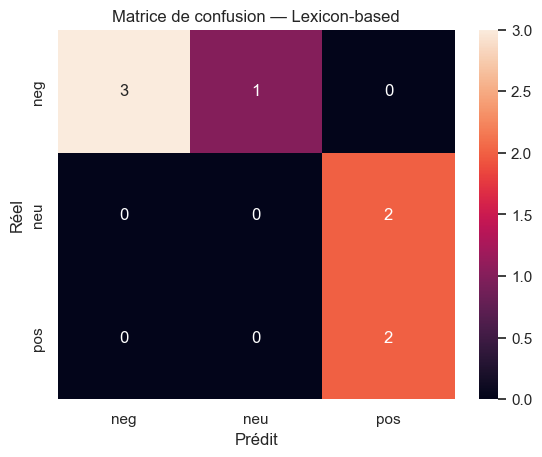

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy (lexicon-based):", accuracy_score(df["sentiment"], df["lex_pred"]))
print("\nClassification report:")
print(classification_report(df["sentiment"], df["lex_pred"], digits=3))

cm = confusion_matrix(df["sentiment"], df["lex_pred"], labels=["negative","neutral","positive"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["neg","neu","pos"], yticklabels=["neg","neu","pos"])
plt.title("Matrice de confusion — Lexicon-based")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


## 5) Approche supervisée : TF/TF-IDF + Naive Bayes


### 5.1 TF + MultinomialNB


### 5.2 TF-IDF + MultinomialNB


### 5.3 Features les plus influentes (Naive Bayes)


## 6) Synthèse (Jour 1)



## 7) Export (optionnel)
